In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import geojson
from shapely.ops import split
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points
import geopandas as gpd
from numpy import ones,vstack
from numpy.linalg import lstsq
import pandas as pd
import csv
import openpyxl
from itertools import islice
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay

In [2]:
input_file = '../Inputs/404_1_cell_position.txt'
wb = openpyxl.Workbook()
ws = wb.worksheets[0]

with open(input_file, 'r') as data:
    reader = csv.reader(data, delimiter='\t')
    for row in reader:
        ws.append(row) 
data = ws.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df_404 = pd.DataFrame(data, index=idx, columns=cols)
cells_centroid_x = df_404['Centroid X µm'].to_numpy(dtype=float)
cells_centroid_y = df_404['Centroid Y µm'].to_numpy(dtype=float)

In [3]:
pixel_size = 0.346
annotations_geo = geojson.load(open('../Inputs/404_01_anotations.geojson','rb'))
#s1_coordinates = np.array(s1_geo[0]["geometry"]["coordinates"][0]) * pixel_size

In [4]:
annotations = dict()
for entry in annotations_geo:
    try:
        if "name" in entry["properties"].keys():
            annotations[entry["properties"]["name"]] = np.array(entry["geometry"]["coordinates"]) * pixel_size
    except KeyError: # annotation without name
        pass

In [5]:
s1_coordinates = annotations['S1'][0]
# These 4 points can not be find via an algo, so we need QuPath annotation
top_left = annotations['TOP_LEFT']
bottom_left = annotations['BOTTOM_LEFT']
top_right = annotations['TOP_RIGHT']
bottom_right = annotations['BOTTOM_RIGHT']
quadrilateral = np.array([top_left, top_right, bottom_right, bottom_left, top_left])

In [6]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [7]:
def getExtrapoledLine(line_string, direction='both', EXTRAPOL_RATIO=1.5):
    'Creates a line extrapoled in both directions'
    p1=np.array(line_string)[0] 
    p2=np.array(line_string)[1]
    if direction == 'both' or direction == 'p1p2':
        a = (p2[0]+EXTRAPOL_RATIO*(p1[0]-p2[0]), p2[1]+EXTRAPOL_RATIO*(p1[1]-p2[1])) 
    else:
        a = p2
    if direction == 'both' or direction == 'p2p1':
        b = (p1[0]+EXTRAPOL_RATIO*(p2[0]-p1[0]), p1[1]+EXTRAPOL_RATIO*(p2[1]-p1[1]))
    else:
        b = p1
    return LineString([a,b])

In [8]:
def create_grid(quadrilateral, s1_coordinates, nb_row, nb_col):
    """
    Args:
        qudrilateral(np.array): shape(5, 2). top_left, top_right, bottom_right, bottom_left, top_left
    """
    top_left = quadrilateral[0]
    top_right = quadrilateral[1]
    bottom_right = quadrilateral[2]
    bottom_left = quadrilateral[3]
    
    # Vertical lines
    lines = [LineString([[top_left[0]-10, top_left[1]], [bottom_left[0]-10, bottom_left[1]]])]
    for i in range(nb_col-1):
        top_point = top_left + (top_right - top_left) / nb_col * (i+1)
        bottom_point = bottom_left + (bottom_right - bottom_left) / nb_col * (i+1)
        line = LineString([(top_point[0], top_point[1]), (bottom_point[0], bottom_point[1])])
        line = getExtrapoledLine(line, 'both', 1.3)
        try:
            intersection_line = Polygon(s1_coordinates).intersection(line).coords
            lines.append(intersection_line)
        except NotImplementedError:
        #    intersection_line = list(Polygon(quadrilateral).intersection(line).coords)
            pass
    lines.append(LineString([top_right, bottom_right]))
              
    # Horizontal lines
    horizontal_lines = []  
    for i in range(nb_row-1):
        horizontal_points = []
        for index, line in enumerate(lines) : 
            line_coord = np.array(line)
            point = line_coord[0] + (line_coord[1] - line_coord[0]) / nb_row * (i+1)
            horizontal_points.append(point)
        horizontal_line = LineString(horizontal_points)
        horizontal_lines.append(horizontal_line)
        
    '''
    left_extended = []
    for horizontal_line in horizontal_lines:
        print(np.array(horizontal_line)[0])
        print(np.array(horizontal_line)[1])
        line_coord = np.array(horizontal_line)
        left_horizontal_line=getExtrapoledLine(LineString([(line_coord[0][0], line_coord[0][1]),
                                                           (line_coord[1][0], line_coord[1][1])]),
                                               'both' , 2.0)
        left_extended.append(left_horizontal_line)
                                                           
        break
    '''
    return lines, horizontal_lines
    
    

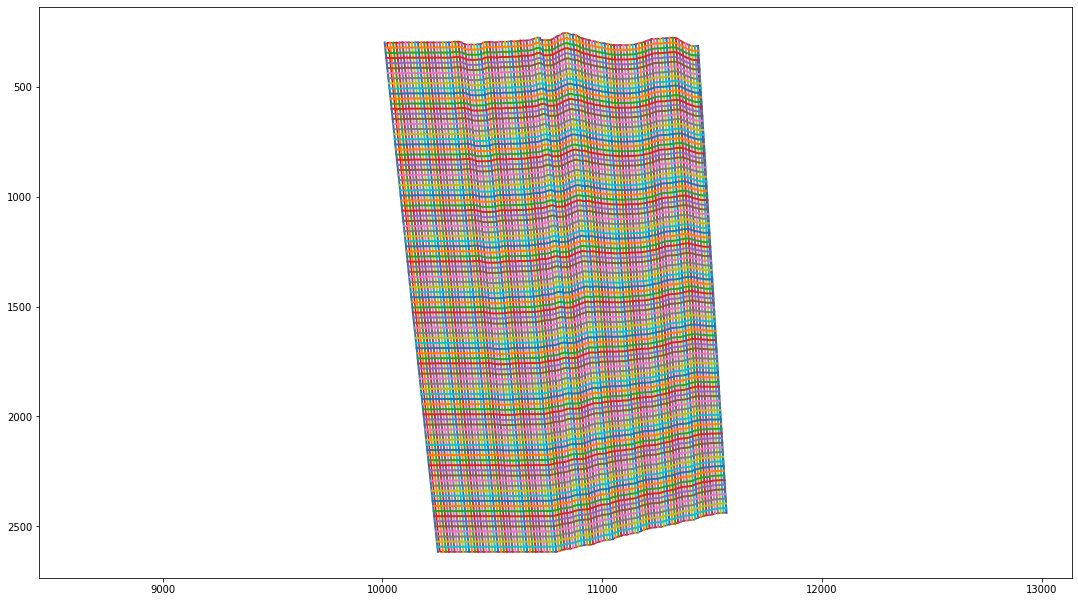

In [9]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.axis('equal')
plt.gca().invert_yaxis()
plt.plot(s1_coordinates[:,0], s1_coordinates[:,1], 'r')

nb_row = 100
vertical_lines, horizontal_lines = create_grid(quadrilateral, s1_coordinates, nb_row, 100)
for line in vertical_lines:
    line_coord = np.array(line)
    plt.plot(line_coord[:,0], line_coord[:,1], linewidth=2)
             

for line in horizontal_lines:
    line_coord = np.array(line)
    plt.plot(line_coord[:,0], line_coord[:,1], linewidth=2)




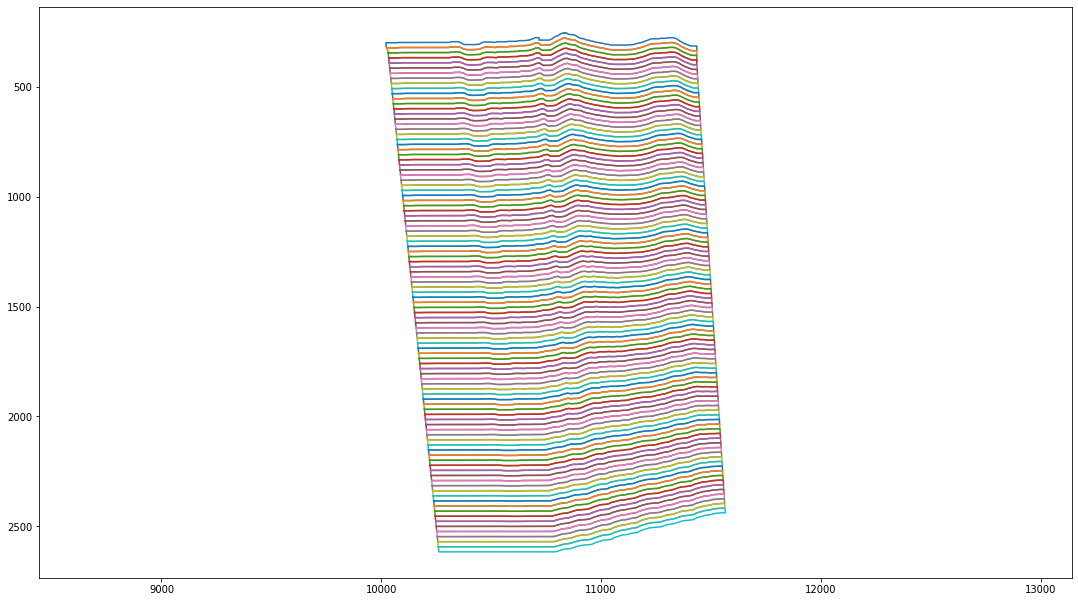

In [10]:
split_polygons = []
polygon_to_split = Polygon(s1_coordinates)
for line in horizontal_lines: 
    split_result = split(polygon_to_split, line)

    polygon_to_split = split_result[1]
    split_polygons.append(split_result[0])

    
split_polygons.append(polygon_to_split)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.axis('equal')
plt.gca().invert_yaxis()
for polygon in split_polygons:
    x,y = polygon.exterior.xy
    plt.plot(x,y)



In [11]:
#cell_coor = np.array([cells_centroid_x[20], cells_centroid_y[20]])
#plt.scatter(cell_coor[0], cell_coor[1], s=50)

nb_cell_per_slide = [0] * nb_row
for x, y in zip (cells_centroid_x, cells_centroid_y):
    for index, polygon in enumerate(split_polygons):
        if polygon.contains(Point([x,y])):
            nb_cell_per_slide[index]+=1

In [12]:
desities = []
z_length = 50 / 1e3 # mm
areas = []
for nb_cell, polygon in zip(nb_cell_per_slide, split_polygons):
    areas.append(polygon.area)
    desities.append(nb_cell/ ((polygon.area / 1e6) * z_length))

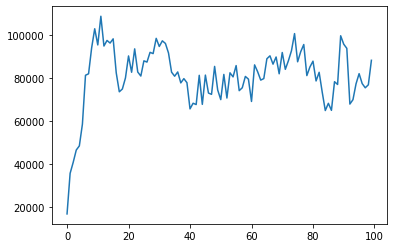

In [13]:
plt.plot([i for i in range(nb_row)], desities)
plt.show()